

# Dataframe related information

### Main dataframes information
###### df_master = Master copy dataframe. Holds all training, test and unsup review and label along with filename.
###### imdb_train = Holds only train data.
###### imdb_test = Holds only test data.
###### imdb_unsup = Holds only unsup data.
###### df_freq = Holds information for frequency analysis and/or holding training and test set together, wherever needed.
###### df_algo = Hold data for all model related work done in Phase 4 and Phase 5

#### At stages provision for loading dataframe in processed state has been commented out. If anyone wishes to load the said csv to reduce some steps please do so my removing comment.(And comment the steps which are redundant to reduce processing load --> This is not necessary for running of code but reduces overhead)

### CSV information
###### train_imdb.csv - Training data seperated from master data. Not cleaned.
###### test_imdb.csv - Test data seperated from master data. Not cleaned.
###### unsup_imdb.csv - Test data seperated from master data. Not cleaned.
###### unsup_clean.csv - Unlabelled data. After cleaning.
###### clean_algo.csv - Combination of train and test data. Clean data.

# Library Section

In [3]:
################################################# import libraries ###########################################

import pandas as pd
import os
from nltk.corpus import stopwords
import string
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import operator
from sklearn.feature_extraction.text import CountVectorizer
# from wordcloud import WordCloud
import time
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.cluster import AgglomerativeClustering

# Modules Section

In [2]:
def rem_sw(df):
    # Downloading stop words
    stop_words = set(stopwords.words('english'))

    # Removing Stop words from training data
    count = 0
    for sentence in df:
        sentence = [word for word in sentence.lower().split() if word not in stop_words]
        sentence = ' '.join(sentence)
        df.loc[count] = sentence
        count+=1
    return(df)

In [3]:
def rem_punc(df):
    count = 0
    for s in df:
        cleanr = re.compile('<.*?>')
        s = re.sub(r'\d+', '', s)
        s = re.sub(cleanr, '', s)
        s = re.sub("'", '', s)
        s = re.sub(r'\W+', ' ', s)
        s = s.replace('_', '')
        df.loc[count] = s
        count+=1
    return(df)

In [4]:
def lemma(df):

    lmtzr = WordNetLemmatizer()

    count = 0
    stemmed = []
    for sentence in df:    
        word_tokens = word_tokenize(sentence)
        for word in word_tokens:
            stemmed.append(lmtzr.lemmatize(word))
        sentence = ' '.join(stemmed)
        df.iloc[count] = sentence
        count+=1
        stemmed = []
    return(df)

In [5]:
def stemma(df):

    stemmer = SnowballStemmer("english") #SnowballStemmer("english", ignore_stopwords=True)

    count = 0
    stemmed = []
    for sentence in df:
        word_tokens = word_tokenize(sentence)
        for word in word_tokens:
            stemmed.append(stemmer.stem(word))
        sentence = ' '.join(stemmed)
        df.iloc[count] = sentence
        count+=1
        stemmed = []
    return(df)

In [4]:
def get_feature(df, number):
    
    feature_list = []
    # create an instance for tree feature selection
    tree_clf = ExtraTreesClassifier()

    # first create arrays holding input and output data

    # Vectorizing Train set
    cv = CountVectorizer(analyzer='word')
    x_train = cv.fit_transform(df['review'])

    # Creating an object for Label Encoder and fitting on target strings
    le = LabelEncoder()
    y = le.fit_transform(df['label'])

    # fit the model
    tree_clf.fit(x_train, y)
    
    # Preparing variables
    importances = tree_clf.feature_importances_
    feature_names = cv.get_feature_names()
    feature_imp_dict = dict(zip(feature_names, importances))
    sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)
    indices = np.argsort(importances)[::-1]

    # Create the feature list
    for f in range(number):
        feature_list.append(sorted_features[f][0])
    
    return(feature_list)

In [5]:
def print_feature(df):
    
    # create an instance for tree feature selection
    tree_clf = ExtraTreesClassifier()

    # first create arrays holding input and output data

    # Vectorizing Train set
    cv = CountVectorizer(analyzer='word')
    x_train = cv.fit_transform(df['review'])

    # Creating an object for Label Encoder and fitting on target strings
    le = LabelEncoder()
    y = le.fit_transform(df['label'])

    # fit the model
    tree_clf.fit(x_train, y)

    # Preparing variables
    importances = tree_clf.feature_importances_
    feature_names = cv.get_feature_names()
    feature_imp_dict = dict(zip(feature_names, importances))
    sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(20):
        print("feature %d : %s (%f)" % (indices[f], sorted_features[f][0], sorted_features[f][1]))

    # Plot the feature importances of the forest
    plt.figure(figsize = (20,20))
    plt.title("Feature importances")
    plt.bar(range(100), importances[indices[:100]],
           color="r", align="center")
    plt.xticks(range(100), sorted_features[:100], rotation=90)
    plt.xlim([-1, 100])
    plt.show()

    return()

In [8]:
def get_bestrf(X, y):
    parameters = [
        {
            "n_estimators":[5, 10, 20, 50, 100],
            "criterion":['gini', 'entropy']
        }
    ]

    best_clf = GridSearchCV(clf, parameters, scoring="accuracy", verbose=5, n_jobs=4)

    best_clf.fit(X, y)
    
    return(best_clf.best_estimator_.n_estimators, best_clf.best_estimator_.criterion)

# Phase 1 Cleaning

## 1.1 Read the labelled data from respective folders (pos & neg) and store in data-frames (eg: train_df & test_df) with suitable structure

In [9]:
############################################# Loading Data for Project ##########################################

# Create master dataset
data = []
main_path = os.path.join(os.path.abspath(''), 'aclImdb')
for head in os.listdir(main_path):
    if os.path.isdir(os.path.join(main_path, head)):
        label_path = os.path.join(os.path.abspath(''), 'aclImdb', head)
        for label in os.listdir(label_path):
            if os.path.isdir(os.path.join(label_path, label)):
                path = os.path.join(os.path.abspath(''), 'aclImdb', head, label)
                files = [f for f in os.listdir(path) if f.endswith(".txt")]
                for fle in files:
       # open the file and then call .read() to get the text 
                    with open(os.path.join(path, fle), encoding='latin-1') as f:
                        text = f.read()
                    data.append([head, text, label, fle])
df_master = pd.DataFrame(data, columns = ['type', 'review', 'label', 'file'])

### Separating the required data from training data

In [109]:
imdb_train = df_master[["review", "label"]][df_master.type.isin(['train'])].reset_index(drop=True)
imdb_test = df_master[["review", "label"]][df_master.type.isin(['test'])].reset_index(drop=True)

## 1.2 Remove stop words from the data

In [11]:
# Loading CSV ---> Use this step to skip collating data from file system 

# imdb_test = pd.read_csv('test_imdb.csv', encoding='latin-1', index_col = 0)
# imdb_train = pd.read_csv('train_imdb.csv', encoding='latin-1', index_col = 0)

In [12]:
##################################### Removing Stop words from training data ##################################

imdb_train['review'] = rem_sw(imdb_train['review'])

In [13]:
##################################### Removing Stop words from testing data ###################################

imdb_test['review'] = rem_sw(imdb_test['review'])

## 1.3 Removing punctuations, HTML tags (like br) etc. 

In [14]:
###################################### Removing punctuations from Train set ##################################

imdb_train['review'] = rem_punc(imdb_train['review'])

In [15]:
###################################### Removing punctuations from Test set ###################################

imdb_test['review'] = rem_punc(imdb_test['review'])

## 1.4 Apply Stemming and Lemmatization

In [16]:
############################################### Stemming Train set ##########################################

imdb_train['review'] = lemma(imdb_train['review'])
imdb_train['review'] = stemma(imdb_train['review'])

In [17]:
############################################### Stemming Test set ###########################################

imdb_test['review'] = lemma(imdb_test['review'])
imdb_test['review'] = stemma(imdb_test['review'])

## 1.ec1 Apply feature selection to select most important words/features and drop others (Bonus)

###### Visualising the best features

Feature ranking:
feature 5414 : bad (0.001480)
feature 52666 : movi (0.001474)
feature 56749 : one (0.001314)
feature 39123 : it (0.001311)
feature 27089 : film (0.001302)
feature 88242 : worst (0.001267)
feature 32152 : great (0.001244)
feature 45381 : like (0.001243)
feature 46463 : love (0.001229)
feature 79811 : time (0.001216)
feature 31559 : good (0.001195)
feature 69686 : see (0.001136)
feature 30485 : get (0.001132)
feature 86327 : wast (0.001106)
feature 86352 : watch (0.001089)
feature 88270 : would (0.001078)
feature 75482 : stori (0.001045)
feature 47642 : make (0.001036)
feature 25256 : even (0.001011)
feature 13311 : charact (0.000998)


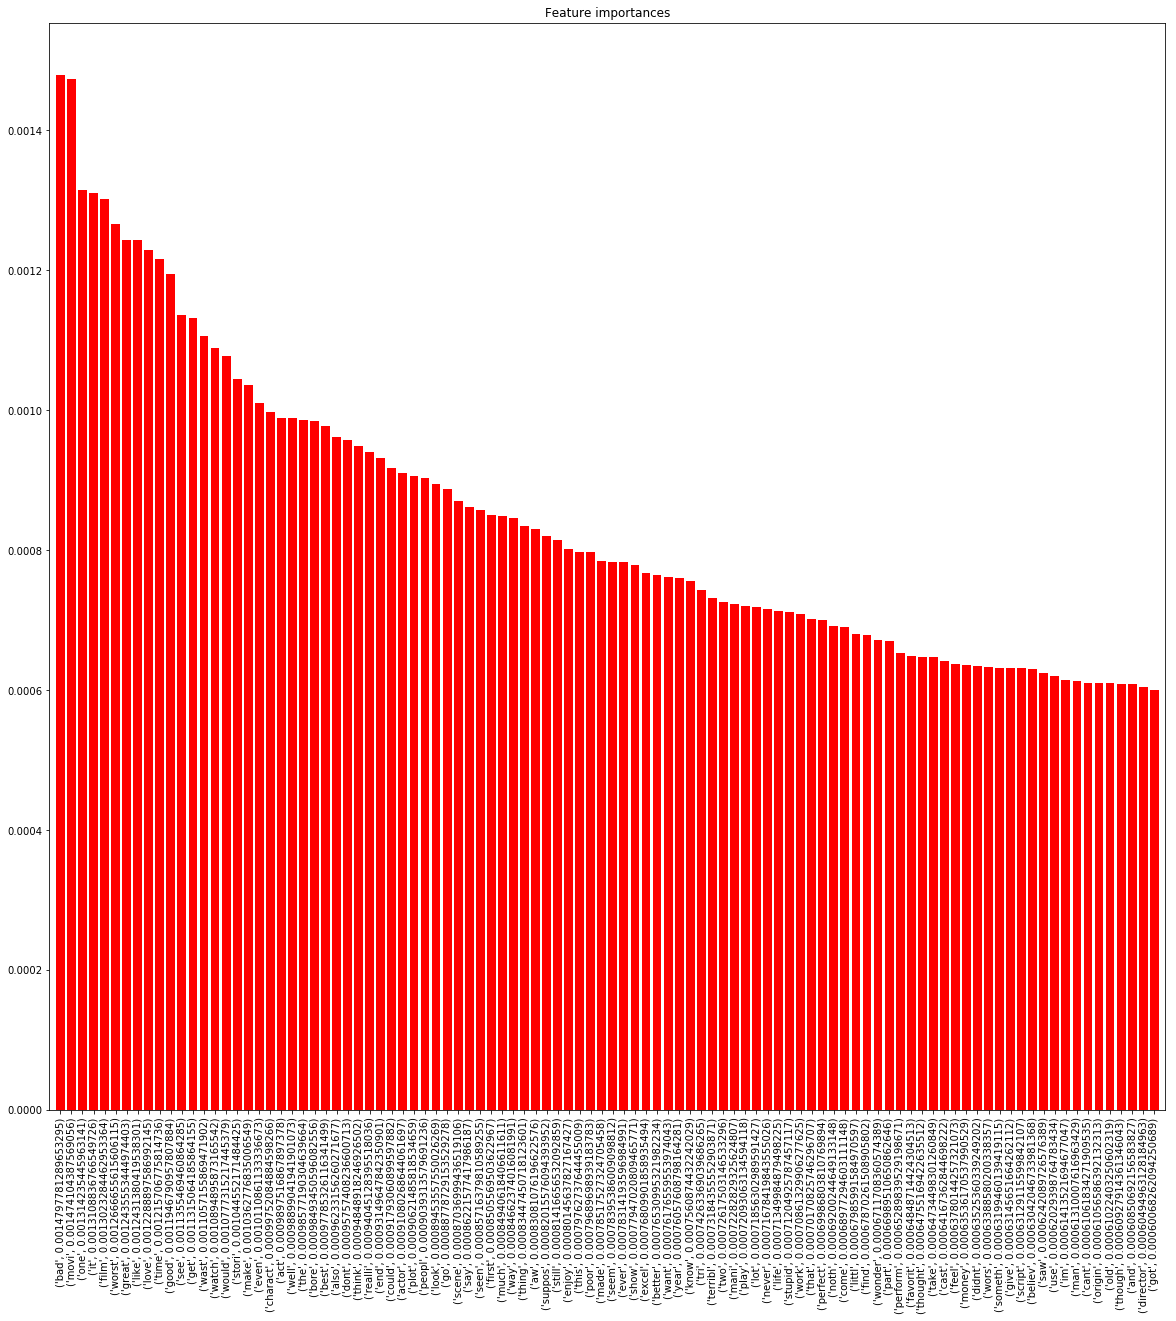

()

In [18]:
############################################# Train set #############################################

print_feature(imdb_train)

Feature ranking:
feature 18403 : great (0.007153)
feature 49764 : worst (0.005600)
feature 43112 : suppos (0.005263)
feature 48635 : wast (0.004813)
feature 5115 : bore (0.004497)
feature 2998 : bad (0.004276)
feature 34351 : poor (0.004249)
feature 2792 : aw (0.003957)
feature 31020 : noth (0.003288)
feature 5627 : brilliant (0.003284)
feature 44219 : terribl (0.002999)
feature 26200 : love (0.002810)
feature 4123 : best (0.002643)
feature 34082 : plot (0.002524)
feature 15161 : favorit (0.002499)
feature 14537 : excel (0.002456)
feature 36255 : recommend (0.002430)
feature 13953 : enjoy (0.002318)
feature 33263 : perfect (0.002156)
feature 49759 : wors (0.002144)


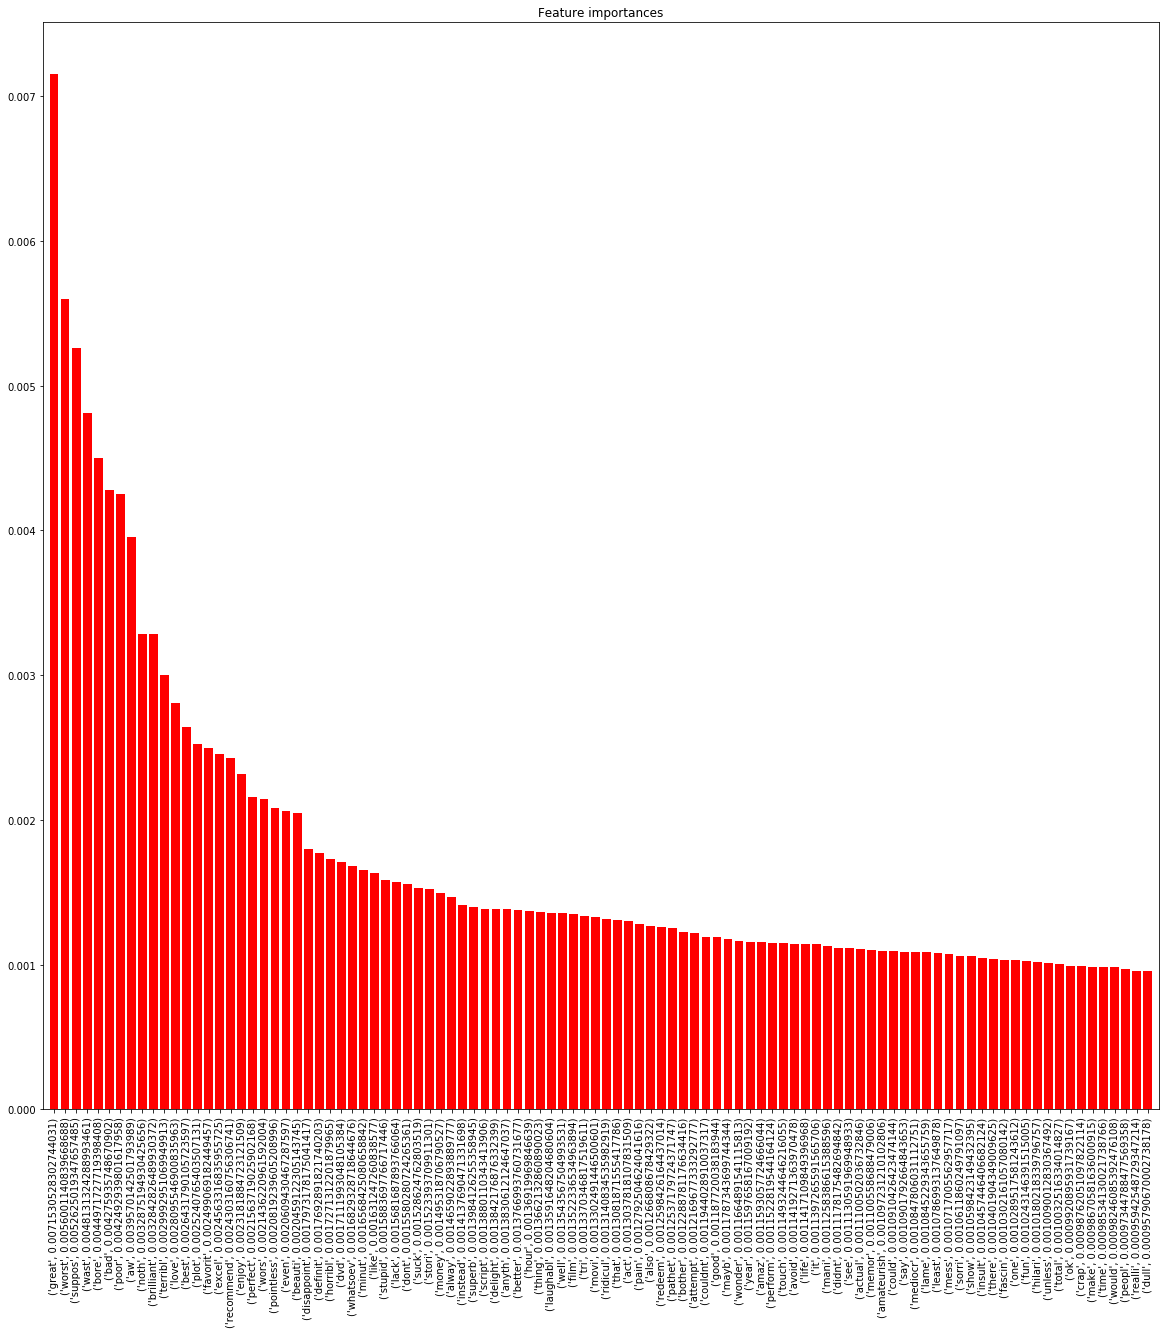

()

In [19]:
############################################# Test set #############################################

print_feature(imdb_test)

# Phase 2 Exploration

## 2.1 For labelled data, find the most common words associated with each category (positive & negative)

In [20]:
###################################### Negative set frequency of train and test combined ################################

# Creating a frequency dataframe of stemmed train and test data set
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)

# Vectorizing negative reviews set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(df_freq[df_freq.label.isin(['neg'])].review)

# Visualising the high frequency words for negative set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
df_freq.nlargest(10, 'frequency')

,frequency
movi,58387
film,44962
like,24640
make,16205
bad,15847
time,15317
watch,14965
good,14918
charact,14319
realli,12353


In [21]:
###################################### Positive set frequency of train and test combined ################################

# Creating a frequency dataframe of stemmed train and test data set
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)

# Vectorizing pos reviews set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(df_freq[df_freq.label.isin(['pos'])].review)

# Visualising the high frequency words for positive set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
df_freq.nlargest(10, 'frequency')

,frequency
film,50860
movi,44822
like,20554
time,16619
good,15261
stori,14180
charact,14017
make,13807
great,13334
watch,12905


## 2.2 Discover the lowest frequency and highest frequency words 

In [22]:
# Creating a frequency dataframe of stemmed train and test data set
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)

# Vectorizing complete review set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(df_freq.review)

# Visualising the high and low frequency words for complete set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
print(df_freq.nlargest(1, 'frequency'), sep='\n')
print(df_freq.nsmallest(1, 'frequency'), sep='\t')

      frequency
movi     206796
       frequency
aaaaa          1


## 2.ec1 Read unlabeled data from respective folder (unsup) and store in unsup_df

In [111]:
imdb_unsup = df_master[["review", "label"]][df_master.label.isin(['unsup'])].reset_index(drop=True)

## 2.ec2 Create a cluster to separate positive and negative words (bonus) using k-means algorithm --- Not Solved

In [113]:
# Cleaning Unlabelled data

imdb_unsup['review'] = rem_sw(imdb_unsup['review'])
imdb_unsup['review'] = rem_punc(imdb_unsup['review'])
imdb_unsup['review'] = lemma(imdb_unsup['review'])
imdb_unsup['review'] = stemma(imdb_unsup['review'])

In [25]:
# Creating the required data for Text Clustering

# imdb_unsup = pd.read_csv("unsup_clean.csv", encoding='latin-1', index_col = 0) # Uncomment this line to load a clean imdb_unsup

# Vectorizing unlabelled reviews set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(imdb_unsup.review)

# Creating a dataframe for the high frequency words for unlabelled reviews set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T

#### I tried multiple combination to get the best cluster division. Initially I tried removing more high frequency words. Then I tried removing low frequency words. The number 100 high frequency words and 43750 low frequency words gave the best results.

In [26]:
# Removing high frequency and low frequency data for more accuracy

word_list = df_freq.nlargest(100, 'frequency').index
word_list = word_list.append(df_freq.nsmallest(43750, 'frequency').index)

In [27]:
# Removing unwanted words based on word_list from unlabelled data
count = 0
for sentence in imdb_unsup['review']:
    sentence = [word for word in sentence.lower().split() if word not in word_list]
    sentence = ' '.join(sentence)
    imdb_unsup.loc[count, 'review'] = sentence
    count+=1

#### We can see that we have 2 clusters: Cluster 0 --> is positive and Cluster 1 --> is negative. In multiple attempts this is the most distinct cluster seperation

In [28]:
##################################### Using K-means to create two clusters ##################################### 

# Vectorizing dataset
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(imdb_unsup.review)
 

# Creating a k-means object and fitting it to target variable
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1, random_state=13)
model.fit(X)
 
# Visualising the 2 clusters
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 beauti
 famili
 excel
 alway
 war
 american
 live
 differ
 perfect
 child
Cluster 1:
 worst
 wast
 bore
 ive
 laugh
 poor
 terribl
 stupid
 aw
 budget


#### We can further improve the clusters by manually removing vague words from each clusters. However,  the manual approach is tedious and improvement of the result is minimal and hence has been dropped.

In [29]:
# Having look at the predicitions for the unlabelled data
Y = vectorizer.transform(imdb_unsup.review)
prediction = model.predict(Y)
# print(prediction)

# Checking labels distribution
Counter(prediction)

Counter({0: 33823, 1: 16177})

# Phase 3 Visualization

## 3.1 Create a word cloud with positive and negative words after cleansing

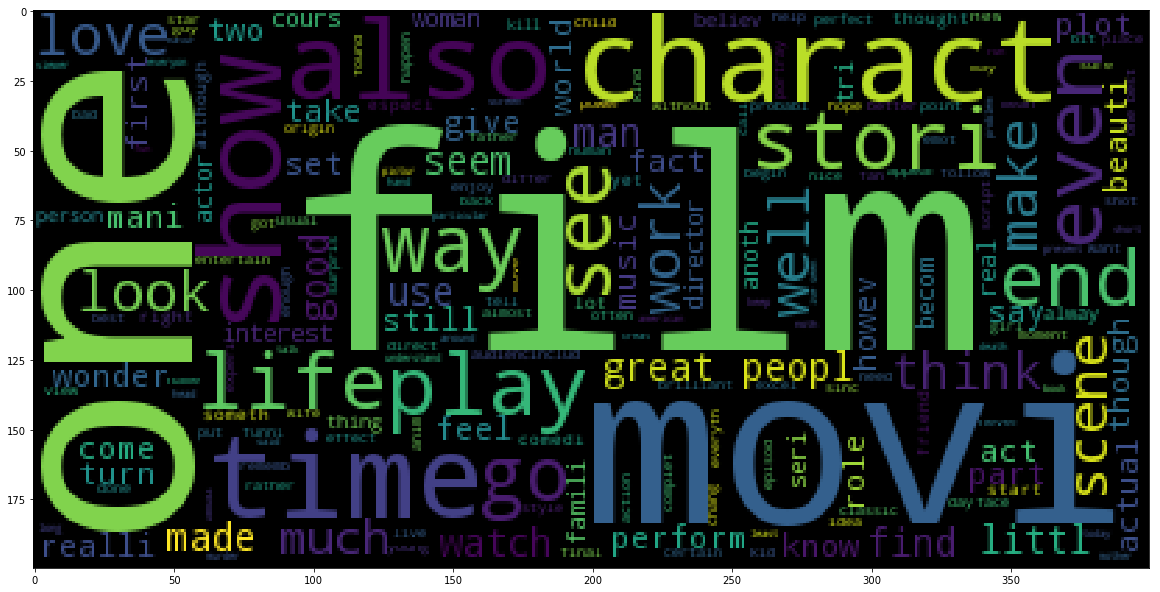

In [30]:
########################## WordCloud Positive Train & Test set ##################################

# Creating a list of train and test data to analyse
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)
imdb_list = df_freq["review"][df_freq.label.isin(['pos'])].unique().tolist()
imdb_bow = " ".join(imdb_list)

# Create a word cloud for psitive words
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

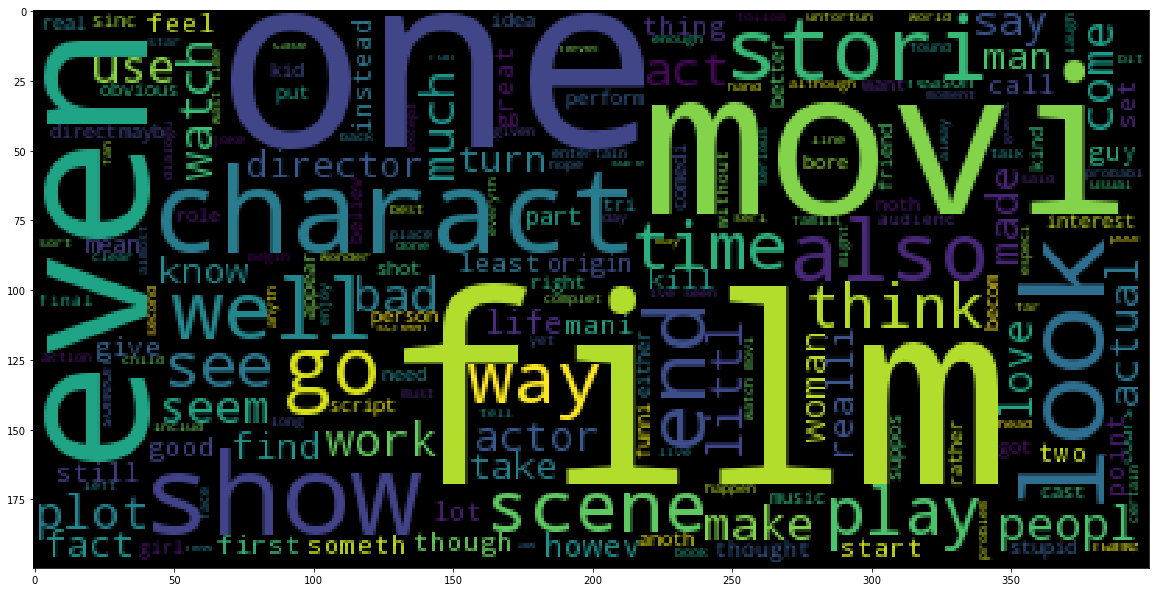

In [31]:
########################## WordCloud Negative Train & Test set ##################################

# Creating a list of train and test data to analyse
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)
imdb_list = df_freq["review"][df_freq.label.isin(['neg'])].unique().tolist()
imdb_bow = " ".join(imdb_list)

# Create a word cloud for negative words
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

## 3.2 Visualise the positive and negative words distribution (Hint: Histogram)

### Positive words histograms

###### We can see that for positive words are of 52004 words, 43464 words fall below 25 frequency

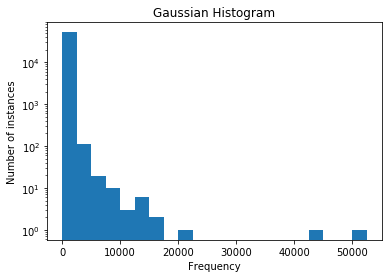

In [32]:
########################## Histogram Positive Train & Test set ##################################

#Combining cleaned train and test data
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)

# Creating an object for Count vectorizer and fitting it to positive dataset
hist_cv = CountVectorizer(stop_words = 'english', analyzer='word')
# hist_pos = hist_cv.fit_transform(df_freq[df_freq.label.isin(['neg'])].review)
hist_pos = hist_cv.fit_transform(df_freq[df_freq.label.isin(['pos'])].review)

# Visualising the histogram for positive reviews only from train and dataset
data = hist_pos.sum(axis=0).tolist()
binwidth = 2500
plt.hist(data[0], bins=range(min(data[0]), max(data[0]) + binwidth, binwidth), log=True)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

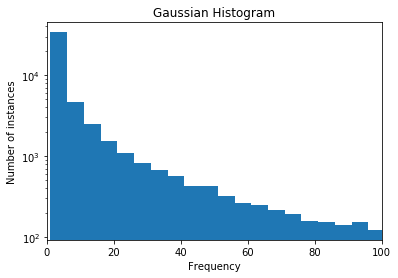

In [33]:
# Zooming in on below 100 frequency words

zoom_data = [f for f in data[0] if f <= 100]
binwidth = 5
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=True)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.xlim(0, 100)
plt.show()

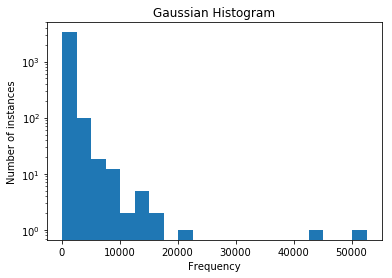

In [34]:
# Having a look at above 100 frequency words more closely

zoom_data = [f for f in data[0] if f > 100]
binwidth = 2500
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=True)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

###### Inference: Words with higher frequency than 1750 are outliers and less than 25 occurence constitute about 80% of the positive data

### Negative words histograms

###### We can see that for negative words of 49786 words, 41957 words fall below 25 frequency

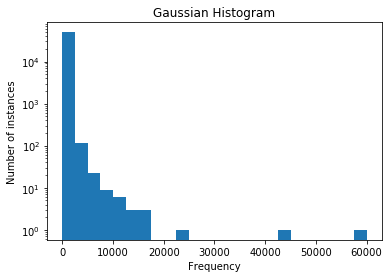

In [35]:
########################## Histogram Negative Train & Test set ##################################

#Combining cleaned train and test data
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)

# Creating an object for Count vectorizer and fitting it to positive dataset
hist_cv = CountVectorizer(stop_words = 'english', analyzer='word')
hist_neg = hist_cv.fit_transform(df_freq[df_freq.label.isin(['neg'])].review)

# Visualising the histogram for positive reviews only from train and dataset
data = hist_neg.sum(axis=0).tolist()
binwidth = 2500
plt.hist(data, bins=range(min(data[0]), max(data[0]) + binwidth, binwidth), log=True)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

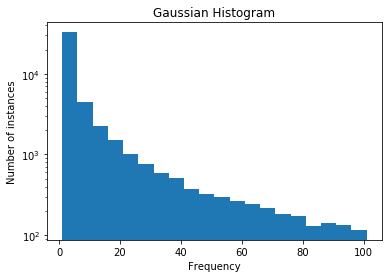

In [36]:
# Having a look at less than 100 frequency words more closely

zoom_data = [f for f in data[0] if f <= 100]
binwidth = 5
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=True)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

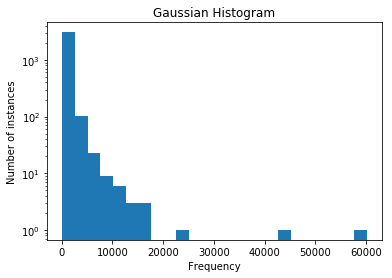

In [37]:
# Having a look at above 100 frequency words more closely

zoom_data = [f for f in data[0] if f > 100]
binwidth = 2500
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=True)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

###### Inference: Words with higher frequency than 1750 are outliers and less than 20 occurence constitute about 80% of the negative data
###### The nature of positive and negative word distribution is pretty similar.

## 3.ec1 Repeat visualization step 1 & 2 after feature selection and note the impact (Bonus)

### Preparing data to repeat visualisation after feature selection

In [38]:
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)

word_list = get_feature(df_freq, 1000)

In [39]:
# Removing non prefered words from training and test combined data
count = 0
for sentence in df_freq['review']:
    sentence = [word for word in sentence.lower().split() if word in word_list]
    sentence = ' '.join(sentence)
    df_freq.loc[count, 'review'] = sentence
    count+=1

#### Visualising Wordcloud after feature selection

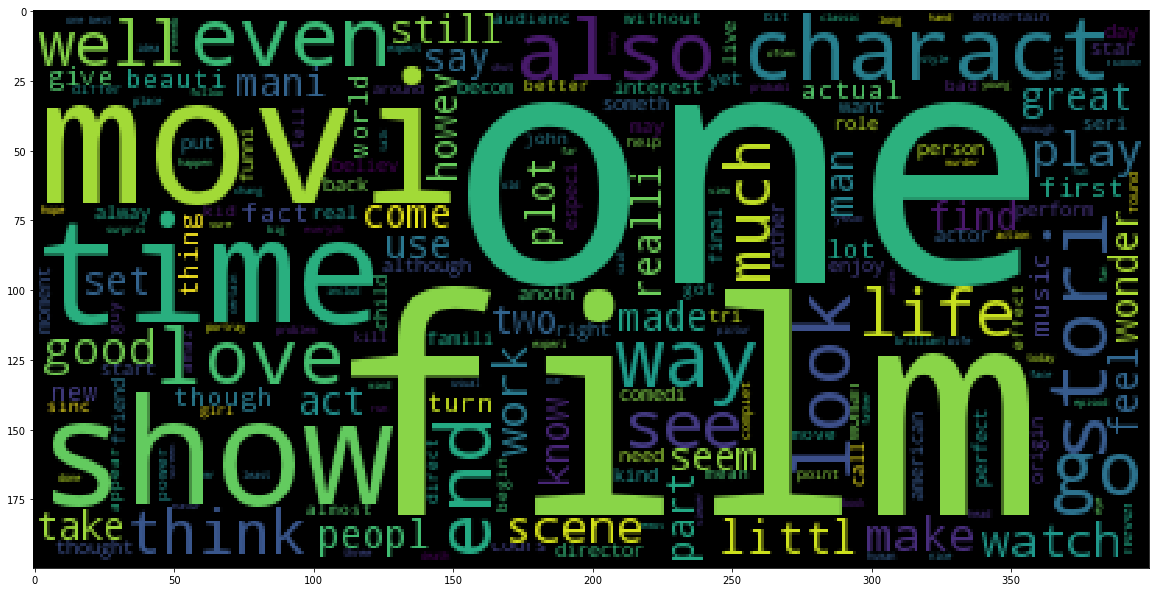

In [40]:
########################## WordCloud Positive Train & Test set post feature selection ##################################

# Creating a list of train and test data to analyse
imdb_list = df_freq["review"][df_freq.label.isin(['pos'])].unique().tolist()
imdb_bow = " ".join(imdb_list)

# Create a word cloud for psitive words
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

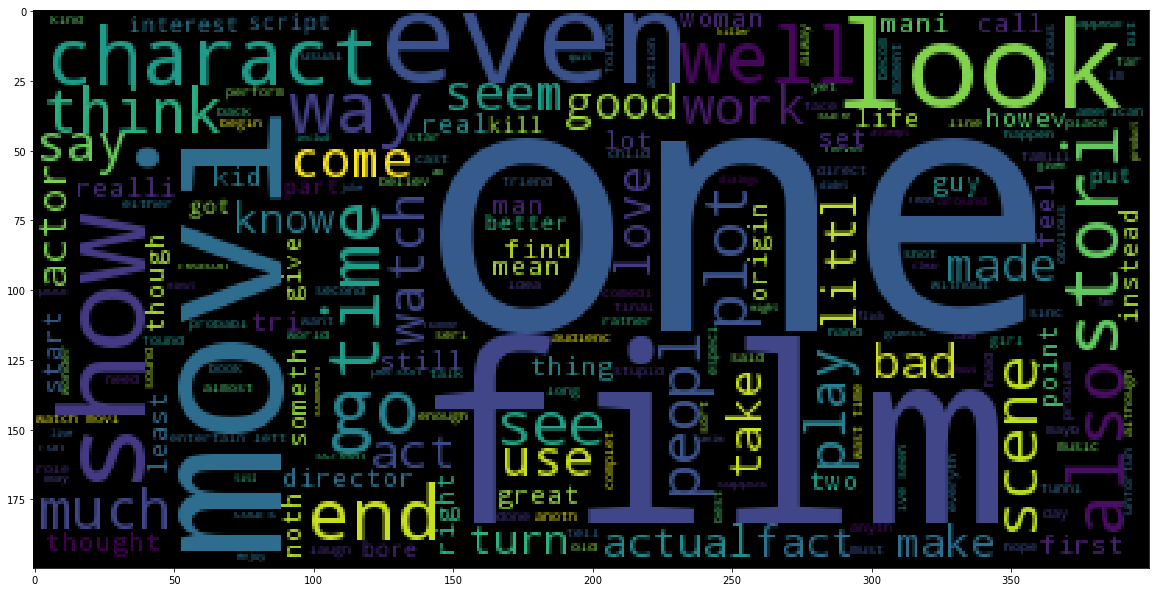

In [41]:
########################## WordCloud Negative Train & Test set post feature selection ##################################

# Creating a list of ham data only to analyse
imdb_list = df_freq["review"][df_freq.label.isin(['neg'])].unique().tolist()
imdb_bow = " ".join(imdb_list)

# Create a word cloud for ham
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

#### Visualising Histogram after feature selection

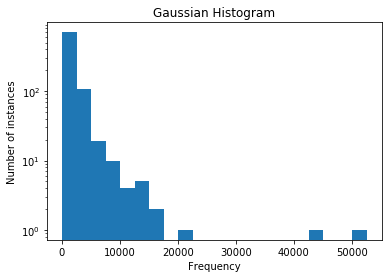

In [42]:
########################## Histogram Positive Train & Test set post feature selection ##################################

# Creating an object for Count vectorizer and fitting it to positive dataset
hist_cv = CountVectorizer(stop_words = 'english', analyzer='word')
hist_pos = hist_cv.fit_transform(df_freq[df_freq.label.isin(['pos'])].review)

# Visualising the histogram for positive reviews only from train and dataset
data = hist_pos.sum(axis=0).tolist()
binwidth = 2500
plt.hist(data, bins=range(min(data[0]), max(data[0]) + binwidth, binwidth), log=True)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

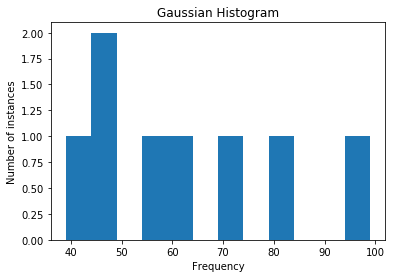

In [43]:
# Having a look at less than 100 frequency words more closely

zoom_data = [f for f in data[0] if f <= 100]
binwidth = 5
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=False)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

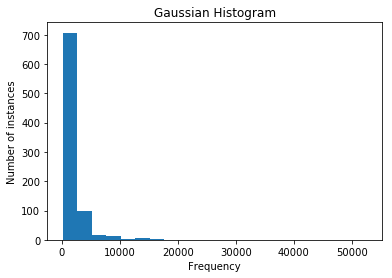

In [44]:
# Having a look at above 100 frequency words more closely

zoom_data = [f for f in data[0] if f > 100]
binwidth = 2500
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=False)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

###### Inference for top 1000 featured words. Positive review distribution shows maximum concentration between 100 to 2600 words. However the outliers at the high end remain the same.

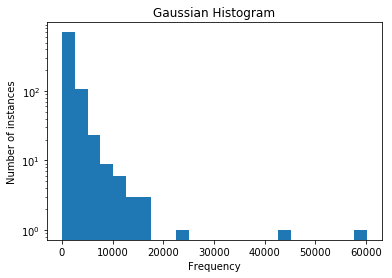

In [45]:
########################## Histogram Negative Train & Test set post feature selection ##################################

# Creating an object for Count vectorizer and fitting it to positive dataset
hist_cv = CountVectorizer(stop_words = 'english', analyzer='word')
hist_pos = hist_cv.fit_transform(df_freq[df_freq.label.isin(['neg'])].review)

# Visualising the histogram for positive reviews only from train and dataset
data = hist_pos.sum(axis=0).tolist()
binwidth = 2500
plt.hist(data, bins=range(min(data[0]), max(data[0]) + binwidth, binwidth), log=True)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

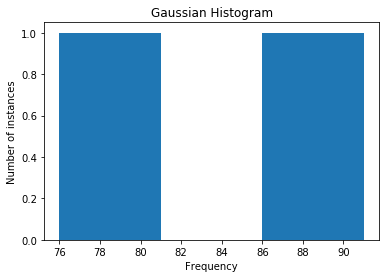

In [46]:
# Having a look at less than 100 frequency words more closely

zoom_data = [f for f in data[0] if f <= 100]
binwidth = 5
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=False)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

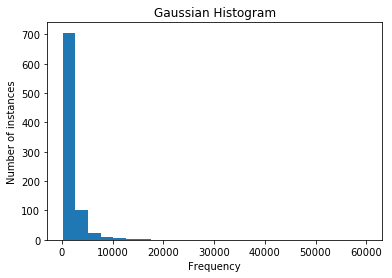

In [47]:
# Having a look at above 100 frequency words more closely

zoom_data = [f for f in data[0] if f > 100]
binwidth = 2500
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=False)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

###### Inference for top 1000 featured words. Negative review distribution shows maximum concentration between 100 to 2600 words. However the outliers at the high end remain the same.

###### Positive and negative label words trend remain similar

## Phase 4 Hypothesis testing  and Feature Selection

### 4.1 Create Hypothesis involving relationships between dependent and independent variables using parametric/non-parametric tests for various machine learning algorithms such as k-means clustering,  classification algorithms.

#### Parametric Test

###### Preparing the data for parametric testing with and without feature

In [115]:
######################## Preparing dataframe which will be the basis of all models ########################

# Creating df_algo dataframe which will be used for hypothesis testing
df_algo = pd.concat([imdb_train, imdb_test], keys=['train', 'test'])
df_algo = df_algo.reset_index(col_level=1).drop(['level_1'], axis=1)

# Cleaning df_algo
df_algo['review'] = rem_sw(df_algo['review'])
df_algo['review'] = rem_punc(df_algo['review'])
df_algo['review'] = lemma(df_algo['review'])
df_algo['review'] = stemma(df_algo['review'])

In [49]:
# Loading csv - Use this code to load a train and test set combination after cleaning

# df_algo = pd.read_csv("clean_algo.csv", encoding='latin-1', index_col = 0) 

In [50]:
################################## Splitting test and train with all data ###############################

# Vectorising the required data
vect_algo = TfidfVectorizer(stop_words='english', analyzer='word')
vect_algo.fit(df_algo.review)
X_train = vect_algo.transform(df_algo[df_algo['level_0'].isin(['train'])].review)
X_test = vect_algo.transform(df_algo[df_algo['level_0'].isin(['test'])].review)

# Encoding target data
# Creating an object and fitting on target strings
le = LabelEncoder()
y = le.fit_transform(df_algo.label)
y_train = le.fit_transform(df_algo[df_algo['level_0'].isin(['train'])].label)
y_test = le.fit_transform(df_algo[df_algo['level_0'].isin(['test'])].label)

###### For feature words we will be using the 80-20 rule or Pareto principle. Hence getting 14440 feature words for word list

In [51]:
################################### Removing non feature words ###############################

# Creating the feature word_list
word_list = get_feature(df_algo[['review', 'label']], 14440)

# Removing non prefered words from training and test combined data
count = 0
for sentence in df_algo['review']:
    sentence = [word for word in sentence.lower().split() if word in word_list]
    sentence = ' '.join(sentence)
    df_algo.loc[count, 'review'] = sentence
    count+=1

In [52]:
################################## Splitting test and train with feature selection data ###############################a

# Vectorising the required data
vect_algo = TfidfVectorizer(stop_words='english', analyzer='word')
vect_algo.fit(df_algo.review)
Xf_train = vect_algo.transform(df_algo[df_algo['level_0'].isin(['train'])].review)
Xf_test = vect_algo.transform(df_algo[df_algo['level_0'].isin(['test'])].review)

# Encoding target data
# Creating an object and fitting on target strings
le = LabelEncoder()
yf_train = le.fit_transform(df_algo[df_algo['level_0'].isin(['train'])].label)
yf_test = le.fit_transform(df_algo[df_algo['level_0'].isin(['test'])].label)

##### Logistic Regression

###### With all data

In [53]:
# Starting time for time calculations
start_time = time.time()

# fit the LR model with x and y 
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# get the predictions off the X test set
predictions = logreg_model.predict(X_test)

# check the accuracy of the model
accuracy = accuracy_score(y_test, predictions)

# Visualising performance: accuracy is adjusted in case model prediction is inverse in the binary state
if accuracy < 0.5:
    accuracy = 1 - accuracy
print("The time taken to execute is %s seconds" % (time.time() - start_time))
print("The accuracy of the model is %.2f%%" % (accuracy*100))

The time taken to execute is 12.025864362716675 seconds
The accuracy of the model is 95.06%


###### With feature selected data

In [54]:
# Starting time for time calculations
start_time = time.time()

# fit the LR model with x and y 
logreg_model = LogisticRegression()
logreg_model.fit(Xf_train, yf_train)

# get the predictions off the X test set
predictions = logreg_model.predict(Xf_test)

# check the accuracy of the model
accuracy = accuracy_score(yf_test, predictions)

# Visualising performance: accuracy is adjusted in case model prediction is inverse in the binary state
if accuracy < 0.5:
    accuracy = 1 - accuracy
print("The time taken to execute is %s seconds" % (time.time() - start_time))
print("The accuracy of the model is %.2f%%" % (accuracy*100))

The time taken to execute is 7.081583738327026 seconds
The accuracy of the model is 94.70%


##### KNN Model

###### With all data - Rejected due to Memory cost

In [55]:
# # Starting time for time calculations
# start_time = time.time()

# # create it's instance
# knn_clf = KNeighborsClassifier(n_neighbors=2)

# # fit the knn with x and y for training
# knn_clf.fit(X_train, y_train)

# # get the predictions from the model 
# predictions = knn_clf.predict(X_test)

# # check the accuracy of the model
# accuracy = accuracy_score(y_test, predictions)

# # Visualising performance: accuracy is adjusted in case model prediction is inverse in the binary state
# if accuracy < 0.5:
#     accuracy = 1 - accuracy
# print("The time taken to execute is %s seconds" % (time.time() - start_time))
# print("The accuracy of the model is %.2f%%" % (accuracy*100))

###### Naive Bayes

###### With all data

In [56]:
# Starting time for time calculations
start_time = time.time()

# fit the classifier model
clf = MultinomialNB()

clf.fit(X_train, y_train)

# predict the outcome for testing data
predictions = clf.predict(X_test)

# check the accuracy of the model
accuracy = accuracy_score(y_test, predictions)

# Visualising performance: accuracy is adjusted in case model prediction is inverse in the binary state
if accuracy < 0.5:
    accuracy = 1 - accuracy
print("The time taken to execute is %s seconds" % (time.time() - start_time))
print("The accuracy of the model is %.2f%%" % (accuracy*100))

The time taken to execute is 0.14936041831970215 seconds
The accuracy of the model is 99.98%


In [57]:
# Starting time for time calculations
start_time = time.time()

# fit the classifier model
clf = MultinomialNB()

clf.fit(Xf_train, yf_train)

# predict the outcome for testing data
predictions = clf.predict(Xf_test)

# check the accuracy of the model
accuracy = accuracy_score(yf_test, predictions)

# Visualising performance: accuracy is adjusted in case model prediction is inverse in the binary state
if accuracy < 0.5:
    accuracy = 1 - accuracy
print("The time taken to execute is %s seconds" % (time.time() - start_time))
print("The accuracy of the model is %.2f%%" % (accuracy*100))

The time taken to execute is 0.10807394981384277 seconds
The accuracy of the model is 98.78%


##### Decision Tree

###### With all data 

In [58]:
# Starting time for time calculations
start_time = time.time()

# Create decision tree object
clf = DecisionTreeClassifier(criterion='gini')

# fit the model
clf.fit(X_train, y_train)

# predict the outcome for testing data
predictions = clf.predict(X_test)

# check the accuracy of the model
accuracy = accuracy_score(y_test, predictions)

# Visualising performance: accuracy is adjusted in case model prediction is inverse in the binary state
if accuracy < 0.5:
    accuracy = 1 - accuracy
print("The time taken to execute is %s seconds" % (time.time() - start_time))
print("The accuracy of the model is %.2f%%" % (accuracy*100))

The time taken to execute is 487.7011203765869 seconds
The accuracy of the model is 78.20%


###### With feature selected data only

In [59]:
# Starting time for time calculations
start_time = time.time()

# Create decision tree object
clf = DecisionTreeClassifier(criterion='gini')

# fit the model
clf.fit(Xf_train, yf_train)

# predict the outcome for testing data
predictions = clf.predict(Xf_test)

# check the accuracy of the model
accuracy = accuracy_score(yf_test, predictions)

# Visualising performance: accuracy is adjusted in case model prediction is inverse in the binary state
if accuracy < 0.5:
    accuracy = 1 - accuracy
print("The time taken to execute is %s seconds" % (time.time() - start_time))
print("The accuracy of the model is %.2f%%" % (accuracy*100))

The time taken to execute is 385.46219277381897 seconds
The accuracy of the model is 78.44%


##### Random Forest

###### With all data

In [60]:
# Assessing the n_estimator and criterion through Grid Search
clf = RandomForestClassifier()

best_estimator, best_criterion = get_bestrf(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 16.1min
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 164.2min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 164.2min finished


In [61]:
# Starting time for time calculations
start_time = time.time()

# Creating the Random forest classifier object
clf = RandomForestClassifier(n_estimators=best_estimator, criterion=best_criterion)

# Fitting the object to the Data
clf.fit(X_train, y_train)

# predict the outcome for testing data
predictions = clf.predict(X_test)

# check the accuracy of the model
accuracy = accuracy_score(y_test, predictions)

# Visualising performance: accuracy is adjusted in case model prediction is inverse in the binary state
if accuracy < 0.5:
    accuracy = 1 - accuracy
print("The time taken to execute is %s seconds" % (time.time() - start_time))
print("The accuracy of the model is %.2f%%" % (accuracy*100))

The time taken to execute is 731.2423899173737 seconds
The accuracy of the model is 99.50%


###### Wih feature selected data

In [62]:
# Assessing the n_estimator and criterion through Grid Search

clf = RandomForestClassifier()

best_estimator, best_criterion = get_bestrf(Xf_train, yf_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  6.7min
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 29.9min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 29.9min finished


In [63]:
# Starting time for time calculations
start_time = time.time()

# Creating the Random forest classifier object
clf = RandomForestClassifier(n_estimators=best_estimator, criterion=best_criterion)

# Fitting the object to the Data
clf.fit(Xf_train, yf_train)

# predict the outcome for testing data
predictions = clf.predict(Xf_test)

# check the accuracy of the model
accuracy = accuracy_score(yf_test, predictions)

# Visualising performance: accuracy is adjusted in case model prediction is inverse in the binary state
if accuracy < 0.5:
    accuracy = 1 - accuracy
print("The time taken to execute is %s seconds" % (time.time() - start_time))
print("The accuracy of the model is %.2f%%" % (accuracy*100))

The time taken to execute is 735.5464818477631 seconds
The accuracy of the model is 99.50%


##### SVM

###### With all data - Rejected due to hung system

In [64]:
# # Starting time for time calculations
# start_time = time.time()

# # import the SVC object 
# svc = SVC()

# # fit the classifier
# svc.fit(X_train, y_train)

# # predict the outcome for testing data
# predictions = svc.predict(X_test)

# # # check the accuracy of the model
# # accuracy = accuracy_score(y_test, predictions)

# # Visualising performance: accuracy is adjusted in case model prediction is inverse in the binary state
# if accuracy < 0.5:
#     accuracy = 1 - accuracy
# print("The time taken to execute is %s seconds" % (time.time() - start_time))
# print("The accuracy of the model is %.2f%%" % (accuracy*100))

###### With feature selected data - Rejected due to hung system

In [65]:
# # Starting time for time calculations
# start_time = time.time()

# # import the SVC object
# svc = SVC()

# # fit the classifier
# svc.fit(Xf_train, yf_train)

# # predict the outcome for testing data
# predictions = svc.predict(Xf_test)

# # # check the accuracy of the model
# # accuracy = accuracy_score(yf_test, predictions)

# # Visualising performance: accuracy is adjusted in case model prediction is inverse in the binary state
# if accuracy < 0.5:
#     accuracy = 1 - accuracy
# print("The time taken to execute is %s seconds" % (time.time() - start_time))
# print("The accuracy of the model is %.2f%%" % (accuracy*100))

#### Non-Parametric test 

##### Kmeans

###### With all data

In [66]:
# Creating unsupervised data from master data
imdb_unsup = df_master[["review", "label"]][df_master.label.isin(['unsup'])].reset_index(drop=True)

# Cleaning Unlabelled data
imdb_unsup['review'] = rem_sw(imdb_unsup['review'])
imdb_unsup['review'] = rem_punc(imdb_unsup['review'])
imdb_unsup['review'] = lemma(imdb_unsup['review'])
imdb_unsup['review'] = stemma(imdb_unsup['review'])

# imdb_unsup = pd.read_csv("unsup_clean.csv", encoding='latin-1', index_col = 0) # Uncomment this line to load from csv

In [67]:
##################################### Using K-means to create two clusters ##################################### 

# Starting time for time calculations
start_time = time.time()

# Vectorizing dataset
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(imdb_unsup.review)
 

# Creating a k-means object and fitting it to target variable
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("The time taken to create clusters is %s seconds" % (time.time() - start_time))
print()

# Visualising the 2 clusters
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

The time taken to create clusters is 77.55127739906311 seconds

Top terms per cluster:
Cluster 0:
 film
 movi
 like
 charact
 time
 stori
 good
 make
 watch
 great
Cluster 1:
 movi
 like
 watch
 bad
 good
 realli
 time
 make
 film
 dont


###### With Feature data

In [68]:
# Removing unwanted words based on word_list from feature selection
# Note: word list still contains best features based on 80-20 rule from parametric test execution
count = 0
for sentence in imdb_unsup['review']:
    sentence = [word for word in sentence.lower().split() if word in word_list]
    sentence = ' '.join(sentence)
    imdb_unsup.loc[count, 'review'] = sentence
    count+=1

In [69]:
##################################### Using K-means to create two clusters ##################################### 

# Starting time for time calculations
start_time = time.time()

# Vectorizing dataset
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(imdb_unsup.review)
 
# Creating a k-means object and fitting it to target variable
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("The time taken to create clusters is %s seconds" % (time.time() - start_time))
print()
 
# Visualising the 2 clusters
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

The time taken to create clusters is 53.87921476364136 seconds

Top terms per cluster:
Cluster 0:
 film
 movi
 like
 charact
 time
 stori
 good
 make
 watch
 great
Cluster 1:
 movi
 like
 watch
 bad
 good
 realli
 time
 make
 dont
 film


##### Hierarchical Clustering

###### With all data ---> Too large for computation

###### With feature selected data --> Choosing top 1000 words for computational ease

In [70]:
############################################# Preparing Data ##################################

# Creating unsupervised data from master data
imdb_unsup = df_master[["review", "label"]][df_master.label.isin(['unsup'])].reset_index(drop=True)

# Cleaning Unlabelled data
imdb_unsup['review'] = rem_sw(imdb_unsup['review'])
imdb_unsup['review'] = rem_punc(imdb_unsup['review'])
imdb_unsup['review'] = lemma(imdb_unsup['review'])
imdb_unsup['review'] = stemma(imdb_unsup['review'])

# imdb_unsup = pd.read_csv("unsup_clean.csv", encoding='latin-1', index_col = 0) # Uncomment this line to load from csv

word_list = get_feature(imdb_unsup, 1000)

# Removing unwanted words based on word_list from feature selection
count = 0
for sentence in imdb_unsup['review']:
    sentence = [word for word in sentence.lower().split() if word in word_list]
    sentence = ' '.join(sentence)
    imdb_unsup.loc[count, 'review'] = sentence
    count+=1

In [71]:
########################################## Hierarchical clustering #############################################

# Starting time for time calculations
start_time = time.time()

# Creating Count vector object
vectorizer = CountVectorizer(analyzer='word')

# Creating Hierarchical Cluster using ward Linkage
# create an instance
n_clusters = 2
model = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")

# Running a manageable loop over the entire dataset
for start in range(0, 50000, 10000):
    # Vectorizing dataset
    X = vectorizer.fit_transform(imdb_unsup.review.iloc[start:(start+10000)])

    # Fit and predict the model
    labels = model.fit_predict(X.toarray())
    imdb_unsup['label'].iloc[start:(start+10000)] = labels

print("The time taken to execute is %s seconds" % (time.time() - start_time))
print()

# Checking labels distribution
Counter(imdb_unsup.label)

The time taken to execute is 166.76027750968933 seconds



Counter({0: 37922, 1: 12078})

###### Comparing Counter results with previous counter results with Kmeans (Counter({0: 33823, 1: 16177})) we can see that results are quite comparable and within a tolerance of approximately 6%

# Phase 5 Model Building

## 5.1 Supervised Learning: Build a sentiment analysis model to predict positive and negative classes 

###### Selecting Naive Bayes for Supervised modelling as it has given the best accuracy and time to execute results

In [74]:
imdb_unsup = df_master[["review", "label"]][df_master.label.isin(['unsup'])].reset_index(drop=True)

# Cleaning Unlabelled data

imdb_unsup['review'] = rem_sw(imdb_unsup['review'])
imdb_unsup['review'] = rem_punc(imdb_unsup['review'])
imdb_unsup['review'] = lemma(imdb_unsup['review'])
imdb_unsup['review'] = stemma(imdb_unsup['review'])

# Creating the required data for Text Clustering
# imdb_unsup = pd.read_csv("unsup_clean.csv", encoding='latin-1', index_col = 0)# Uncomment this line to load from csv

# Vectorizing unlabelled reviews set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(imdb_unsup.review)

# Creating a dataframe for the high frequency words for unlabelled reviews set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T

# Removing high frequency and low frequency data for more accuracy
word_list = df_freq.nlargest(100, 'frequency').index
word_list = word_list.append(df_freq.nsmallest(43750, 'frequency').index)

# Removing unwanted words based on word_list from unlabelled data
count = 0
for sentence in imdb_unsup['review']:
    sentence = [word for word in sentence.lower().split() if word not in word_list]
    sentence = ' '.join(sentence)
    imdb_unsup.loc[count, 'review'] = sentence
    count+=1

In [72]:
################################## Preparing dataframe for model ##############################

# Creating df_algo dataframe which will be used for hypothesis testing
df_algo = pd.concat([imdb_train, imdb_test], keys=['train', 'test'])
df_algo = df_algo.reset_index(col_level=1).drop(['level_1'], axis=1)

# Cleaning the dataset
df_algo['review'] = rem_sw(df_algo['review'])
df_algo['review'] = rem_punc(df_algo['review'])
df_algo['review'] = lemma(df_algo['review'])
df_algo['review'] = stemma(df_algo['review'])

# df_algo = pd.read_csv("clean_algo.csv", encoding='latin-1', index_col = 0) # Uncomment this line to load from csv

################################### Removing non feature words ###############################

# Creating the feature word_list
# Selecting 14440 feature selected words based on 80-20 rule
word_list = get_feature(df_algo[['review', 'label']], 14440)

# Removing non prefered words from training and test combined data
count = 0
for sentence in df_algo['review']:
    sentence = [word for word in sentence.lower().split() if word in word_list]
    sentence = ' '.join(sentence)
    df_algo.loc[count, 'review'] = sentence
    count+=1

################################## Splitting with feature selection data ###############################a

# Vectorising the required data
vect_algo = TfidfVectorizer(stop_words='english', analyzer='word')
vect_algo.fit(df_algo.review)
Xf_train = vect_algo.transform(df_algo[df_algo['level_0'].isin(['train'])].review)
Xf_test = vect_algo.transform(df_algo[df_algo['level_0'].isin(['test'])].review)

# Encoding target data
# Creating an object and fitting on target strings
le = LabelEncoder()
yf_train = le.fit_transform(df_algo[df_algo['level_0'].isin(['train'])].label)
yf_test = le.fit_transform(df_algo[df_algo['level_0'].isin(['test'])].label)

In [73]:
########################################### Naive Bayes #########################################

# Fit the Naive Bayes classifier model to the object
clf = MultinomialNB()
clf.fit(Xf_train, yf_train)

# predict the outcome for testing data
predictions = clf.predict(Xf_test)

# check the accuracy of the model
accuracy = accuracy_score(yf_test, predictions)
print("Observation: Naive Bayes Classification gives an accuracy of %.2f%% on the testing data" %(accuracy*100))

Observation: The supervised learning gives an accuracy of 5.27% on the testing data


###### When the  accurracy is low we should send the prediction through a filter which changes 0 to 1 and 1 to 0. Real accuracy will be 100 - current accuracy.

## 5.2 Unsupervised Learning: Build a clustering model consisting of 2 clusters based on positive and negative reviews 

###### Selecting 100 largest and 43750 lowest frequency words for Unsupervised learning. The numbers have been decided based on numerous iterations done during Hypothesis testing. These numbers gave the most distinct clusters.

In [75]:
##################################### Using K-means to create two clusters ##################################### 

# Vectorizing dataset
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(imdb_unsup.review)
 
# Creating a k-means object and fitting it to target variable
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)
 
# Visualising the 2 clusters
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 beauti
 famili
 alway
 excel
 war
 american
 differ
 perfect
 saw
 entertain
Cluster 1:
 worst
 wast
 bore
 ive
 laugh
 poor
 terribl
 stupid
 aw
 budget


In [76]:
# Prediction for test set using Kmeans clusters
Y = vectorizer.transform(imdb_test.review)
prediction = model.predict(Y)

# Actual results of test sets for comparison
le = LabelEncoder()
y = le.fit_transform(imdb_test.label)

# check the accuracy of the model
accuracy = accuracy_score(y, prediction)
if accuracy < 0.5:
    accuracy = 1 - accuracy
print("Observation: The unsupervised learning gives an accuracy of %.2f%% on the testing data" %(accuracy*100))

Observation: The unsupervised learning gives an accuracy of 71.43% on the testing data


In [77]:
################ Creating a word list for Hierarchical learning later ##################

hc_word_list = []
for i in range(true_k):
    for ind in order_centroids[i, :5000]:
        hc_word_list.append(terms[ind])

## 5.ec1 Supervised Learning: Compare the performance of different machine learning models, at least 2 

###### Using Random tree classifier

In [78]:
####################################### Random tree Classification ########################################

# Assessing the n_estimators and criterion parameters through Grid Search
clf = RandomForestClassifier()
best_estimator, best_criterion = get_bestrf(Xf_train, yf_train)

# Calling the random forest object with best parameters
clf = RandomForestClassifier(n_estimators=best_estimator, criterion=best_criterion)

# Fitting the random forest object to the dataset
clf.fit(Xf_train, yf_train)

# predict the outcome for testing data
predictions = clf.predict(Xf_test)

# check the accuracy of the model
accuracy = accuracy_score(yf_test, predictions)
print("Observation: Random tree classification gives an accuracy of %.2f%% on the testing data" %(accuracy*100))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 29.7min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 29.7min finished


Observation: Random tree classification gives an accuracy of 0.51% on the testing data


###### When the  accurracy is low we should send the prediction through a filter which changes 0 to 1 and 1 to 0. Real accuracy will be 100 - current accuracy.

###### Using Logistic Regression

In [79]:
########################################### Logistic Regression #########################################

# fit the LR model with x and y 
logreg_model = LogisticRegression()
logreg_model.fit(Xf_train, yf_train)

# get the predictions off the X test set
predictions = logreg_model.predict(Xf_test)

# check the accuracy of the model
accuracy = accuracy_score(yf_test, predictions)
print("Observation: The Logistic Regression gives an accuracy of %.2f%% on the testing data" %(accuracy*100))

Observation: Naive Bayes Classification gives an accuracy of 1.11% on the testing data


###### When the  accurracy is low we should send the prediction through a filter which changes 0 to 1 and 1 to 0. Real accuracy will be 100 - current accuracy.

## 5.ec2 Unsupervised Learning: Compare the performance of different models, at least 2

###### Using Hierarchical Clustering

In [89]:
# Creating test data from master data
imdb_test = df_master[["review", "label"]][df_master.type.isin(['test'])].reset_index(drop=True)

# Cleaning test data

imdb_test['review'] = rem_sw(imdb_test['review'])
imdb_test['review'] = rem_punc(imdb_test['review'])
imdb_test['review'] = lemma(imdb_test['review'])
imdb_test['review'] = stemma(imdb_test['review'])

# # Creating the required data for Text Clustering
# df_algo = pd.read_csv("clean_algo.csv", encoding='latin-1', index_col = 0)# Un comment this line for clean train and test set
# imdb_test = df_algo[['review', 'label']][df_algo['level_0'] == 'test'].reset_index(drop=True) # Uncomment this line for test

# Removing unwanted words based on hc_word_list(kmeans top clustered words) from unlabelled data
count = 0
for sentence in imdb_test['review']:
    sentence = [word for word in sentence.lower().split() if word in hc_word_list]
    sentence = ' '.join(sentence)
    imdb_test.loc[count, 'review'] = sentence
    count+=1

In [90]:
# Data Preparation - Reproducing hierarchical clustering data
prediction = []

# Vectorizing dataset
vect = CountVectorizer(analyzer='word')

# Creating Hierarchical Cluster using ward Linkage
# create an instance
n_clusters = 2
model = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")

# Vectorizing the dataset
X = vect.fit_transform(imdb_test.review.iloc[10000:20000])

# Predicting the values
prediction.extend(model.fit_predict(X.toarray()))

# for start in range(0, 25000, 5000):
#     # Vectorizing the dataset
#     X = vect.fit_transform(imdb_test.review.iloc[start:(start+5000)])
    
#     # Predicting the values
#     prediction.extend(model.fit_predict(X.toarray()))

In [91]:
# Actual results of test sets for comparison
le = LabelEncoder()
y = le.fit_transform(imdb_test.label[10000:20000])

# check the accuracy of the model
accuracy = accuracy_score(y, prediction)
if accuracy < 0.5:
    accuracy = 1 - accuracy
print("Observation: The hierarchical learning gives an accuracy of %.2f%% on the testing data" %(accuracy*100))

Observation: The hierarchical learning gives an accuracy of 70.94% on the testing data


## 5.ec3 Divide the data into 4 clusters to enable finding more classes. Analyse each cluster and try to find the correct label for the new cluster. Repeat clustering until 4 new labels can be found, other than the original labels (positive and negative)

In [92]:
imdb_unsup = df_master[["review", "label"]][df_master.label.isin(['unsup'])].reset_index(drop=True)

# Cleaning Unlabelled data

imdb_unsup['review'] = rem_sw(imdb_unsup['review'])
imdb_unsup['review'] = rem_punc(imdb_unsup['review'])
imdb_unsup['review'] = lemma(imdb_unsup['review'])
imdb_unsup['review'] = stemma(imdb_unsup['review'])

# Creating the required data for Text Clustering
# imdb_unsup = pd.read_csv("unsup_clean.csv", encoding='latin-1', index_col = 0)# Uncomment this line to load clean unlabeled data

# Vectorizing unlabelled reviews set
vect = CountVectorizer(analyzer='word')
vect_pos = vect.fit_transform(imdb_unsup.review)

# Creating a dataframe for the high frequency words for unlabelled reviews set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T

# Removing high frequency and low frequency data for more accuracy

word_list = df_freq.nlargest(100, 'frequency').index
word_list = word_list.append(df_freq.nsmallest(43750, 'frequency').index)

# Removing unwanted words based on word_list from unlabelled data
count = 0
for sentence in imdb_unsup['review']:
    sentence = [word for word in sentence.lower().split() if word not in word_list]
    sentence = ' '.join(sentence)
    imdb_unsup.loc[count, 'review'] = sentence
    count+=1

In [93]:
##################################### Using K-means to create clusters ##################################### 

# Vectorizing dataset
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(imdb_unsup.review)
 
# Creating a k-means object and fitting it to target variable
true_k = 9
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1, random_state=13)
model.fit(X)
 
# Visualising the clusters
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 comedi
 laugh
 joke
 humor
 hilari
 romant
 fun
 grant
 sandler
 expect
Cluster 1:
 music
 song
 danc
 sing
 wonder
 beauti
 band
 dvd
 number
 saw
Cluster 2:
 episod
 seri
 season
 tv
 televis
 dvd
 origin
 ive
 fan
 hope
Cluster 3:
 anim
 cartoon
 disney
 bambi
 kid
 voic
 origin
 seri
 child
 adult
Cluster 4:
 origin
 kill
 john
 pretti
 fun
 fan
 quit
 turn
 big
 wonder
Cluster 5:
 worst
 wast
 minut
 terribl
 bore
 poor
 ive
 aw
 script
 money
Cluster 6:
 world
 famili
 war
 child
 american
 young
 beauti
 person
 live
 human
Cluster 7:
 book
 game
 read
 novel
 adapt
 version
 chang
 base
 origin
 seri
Cluster 8:
 horror
 zombi
 gore
 kill
 scari
 dead
 effect
 flick
 slasher
 killer


###### From above we get the following genres:-
###### Cluster 0 - Comedy, Romance, Romantic Comedy
###### Cluster 1 - Musical, Feel Good, Inspirational
###### Cluster 2 - Television Series
###### Cluster 3 - Cartoon, Animation, Disney
###### Cluster 4 - Action, Thriller, Mystery
###### Cluster 5 - Reality, Drama
###### Cluster 6 - War, Political, History
###### Cluster 7 -  Children, Adaptation
###### Cluster 8 -  Horror, Thriller

## 5.ec4 Active Learning: Cluster the training dataset and try and find the genre. Manually annotate the cluster and then try to find the labels in the new testing dataset. 

In [6]:
# Loading the required dataset
df_algo = pd.concat([imdb_train, imdb_test], keys=['train', 'test'])
df_algo = df_algo.reset_index(col_level=1).drop(['level_1'], axis=1)

# Cleaning the dataset
df_algo['review'] = rem_sw(df_algo['review'])
df_algo['review'] = rem_punc(df_algo['review'])
df_algo['review'] = lemma(df_algo['review'])
df_algo['review'] = stemma(df_algo['review'])

# Loading Clean train and test set together
# df_algo = pd.read_csv("clean_algo.csv", encoding='latin-1', index_col = 0)# Un comment this line for clean train and test set

# Vectorizing df_algo reviews set
vect = CountVectorizer(analyzer='word')
X_genre = vect.fit_transform(df_algo.review)

# Creating a dataframe for the high frequency words for df_algo reviews set
df_freq = pd.DataFrame(X_genre.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T

# Removing high frequency and low frequency data for more accuracy
word_list = df_freq.nlargest(100, 'frequency').index
word_list = word_list.append(df_freq.nsmallest(43750, 'frequency').index)

# Removing unwanted words based on word_list from df_algo data
count = 0
for sentence in df_algo['review']:
    sentence = [word for word in sentence.lower().split() if word not in word_list]
    sentence = ' '.join(sentence)
    df_algo.loc[count, 'review'] = sentence
    count+=1

In [7]:
##################################### Using K-means to create enough clusters ##################################### 

# Vectorizing dataset
vectorizer = TfidfVectorizer(stop_words='english')
X_genre = vectorizer.fit_transform(df_algo[df_algo['level_0'].isin(['train'])].review)
 
# Creating a k-means object and fitting it to target variable
true_k = 9
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1, random_state=13)
model.fit(X_genre)
 
# Visualising the clusters
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 comedi
 laugh
 joke
 humor
 hilari
 romant
 fun
 moment
 expect
 line
Cluster 1:
 young
 beauti
 world
 wonder
 famili
 day
 war
 quit
 american
 live
Cluster 2:
 horror
 zombi
 gore
 scari
 kill
 slasher
 dead
 effect
 flick
 budget
Cluster 3:
 episod
 seri
 season
 tv
 televis
 dvd
 fan
 alway
 hope
 air
Cluster 4:
 worst
 wast
 minut
 bore
 terribl
 ive
 aw
 poor
 script
 money
Cluster 5:
 book
 read
 novel
 adapt
 version
 chang
 base
 disappoint
 seri
 ive
Cluster 6:
 anim
 kid
 disney
 cartoon
 child
 adult
 famili
 voic
 parent
 saw
Cluster 7:
 action
 game
 fight
 martial
 sequenc
 art
 fan
 fu
 kung
 hero
Cluster 8:
 origin
 version
 sequel
 remak
 dvd
 saw
 classic
 effect
 tv
 seri


###### From above we get the following genres:-
###### Cluster 0 - Musical, Drama
###### Cluster 1 - Adaptation from literature
###### Cluster 2 - Drama
###### Cluster 3 - Horror, Mystery, Thriller
###### Cluster 4 - Action
###### Cluster 5 - Documentary
###### Cluster 6 - Fantasy, Adventure
###### Cluster 7 -  Comedy, Romance, Rom-Com
###### Cluster 8 -  Television series or show

In [19]:
################## Creating training set and prediction set from df_algo and clustering results #####################

# Creating train set
al_train = pd.DataFrame(df_algo[['review']][df_algo['level_0'] == 'train'])
al_train['genre'] = model.labels_

# Creating prediction set
al_pred = pd.DataFrame(df_algo[df_algo['level_0'].isin(['test'])].review)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75000 entries, 0 to 74999
Data columns (total 2 columns):
review    75000 non-null object
genre     75000 non-null int32
dtypes: int32(1), object(1)
memory usage: 1.4+ MB


In [25]:
################################## Data preparation with all data ###############################

# Vectorising the required data
vect_algo = TfidfVectorizer(stop_words='english', analyzer='word')
vect_algo.fit(df_algo.review)
X_train = vect_algo.transform(al_train.review)
X_test = vect_algo.transform(al_pred.review)

# Encoding target data
# Creating an object and fitting on target strings
le = LabelEncoder()
y = le.fit_transform(df_algo.label)
y_train = le.fit_transform(al_train.genre)

In [26]:
############################# Using Logistic regression to predict imdb_test #################################

# fit the LR model with x and y 
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# get the predictions off the X test set
predictions = logreg_model.predict(X_test)

# Assigning prediction to prediction set
al_pred['genre'] = predictions

####################################### End ##########################################